# Tree based methods

J. Renero<br>

Trees construct prediction models from data. They recursively partition the data space to fit a boolean prediction model within each partition. The result is represented graphically as a decision tree. Trees can be used for regression of classification.

When the number of features, $p$, is large interpretability is easier than in distance based methods or probabilistic classification, where boundaries are much more difficult to be explained in higer dimensions.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tree-based-methods" data-toc-modified-id="Tree-based-methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tree based methods</a></span><ul class="toc-item"><li><span><a href="#Regression-Example" data-toc-modified-id="Regression-Example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Regression Example</a></span><ul class="toc-item"><li><span><a href="#Load-the-data-and-split-the-dataset" data-toc-modified-id="Load-the-data-and-split-the-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load the data and split the dataset</a></span></li><li><span><a href="#Fit-a-simple-regression-tree-(no-CV)" data-toc-modified-id="Fit-a-simple-regression-tree-(no-CV)-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fit a simple regression tree (no CV)</a></span></li><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-Importance" data-toc-modified-id="Variables-Importance-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Variables Importance</a></span></li><li><span><a href="#Understanding-the-tree-structure-(partially-from-here)" data-toc-modified-id="Understanding-the-tree-structure-(partially-from-here)-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Understanding the tree structure (partially from <a href="https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py" target="_blank">here</a>)</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Evaluating the tree</a></span></li></ul></li><li><span><a href="#Classification-Example" data-toc-modified-id="Classification-Example-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classification Example</a></span><ul class="toc-item"><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-importance" data-toc-modified-id="Variables-importance-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Variables importance</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluating the tree</a></span></li><li><span><a href="#Manually-finding-the-optimal-tree-depth" data-toc-modified-id="Manually-finding-the-optimal-tree-depth-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Manually finding the optimal tree depth</a></span></li><li><span><a href="#Cost-Complexity-Pruning" data-toc-modified-id="Cost-Complexity-Pruning-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Cost Complexity Pruning</a></span></li><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Working-with-the-probabilities-of-the-estimations" data-toc-modified-id="Working-with-the-probabilities-of-the-estimations-1.2.7"><span class="toc-item-num">1.2.7&nbsp;&nbsp;</span>Working with the probabilities of the estimations</a></span></li><li><span><a href="#Laplacian-Correction-(Smoothing)" data-toc-modified-id="Laplacian-Correction-(Smoothing)-1.2.8"><span class="toc-item-num">1.2.8&nbsp;&nbsp;</span>Laplacian Correction (Smoothing)</a></span></li></ul></li><li><span><a href="#Optimization-techniques" data-toc-modified-id="Optimization-techniques-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Optimization techniques</a></span><ul class="toc-item"><li><span><a href="#Bagging" data-toc-modified-id="Bagging-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Bagging</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Boosting</a></span></li></ul></li><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Hyperparameter tuning</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import graphviz
import warnings

from IPython.display import Image
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from sklearn.metrics import f1_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.validation import column_or_1d
from tqdm import tqdm_notebook

from lime.lime_tabular import LimeTabularExplainer

from dataset import Dataset

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

%matplotlib inline

/Users/renero/miniconda3/envs/ie/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "
/Users/renero/miniconda3/envs/ie/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# These are methods I use along the notebook
def plot_compare(d, label, new_training_score, new_test_score, ymin=0.91, ymax=0.97):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(9, 7))
    pd.DataFrame(d).set_index([pd.Index(['training', 'test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.show()


def features_importance(tree, X):
    """
    Plot the variables importance from the fitted tree and the 
    training dataset used.
    """
    importances = tree.feature_importances_
    indices = np.argsort(importances)

    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 4))
    plt.title("Feature importances")
    plt.barh(range(X.train.shape[1]), importances[indices],
             color="r", align="center")
    index_names = [list(X.train)[i] for i in indices]
    plt.yticks(range(X.train.shape[1]), index_names)
    plt.ylim([-1, X.train.shape[1]])
    plt.xlim([0.0, 1.0])
    plt.show()

## Regression Example

We will start by building a simple regression example with the [wholesale customer dataset in UCI](https://archive.ics.uci.edu/ml/datasets/wholesale+customers). It contains 440 samples of 8 variables, and we will try to build a model that will help us to predict the annual spending on fresh products (first variable) with a regression tree.

### Load the data and split the dataset

In [3]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.set_target('Fresh')
X, Y = wholesale.split()
regression_results = {}
wholesale.all.head()

,Channel,Region,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Fresh
0,2.0,3.0,9656.0,7561.0,214.0,2674.0,1338.0,12669.0
1,2.0,3.0,9810.0,9568.0,1762.0,3293.0,1776.0,7057.0
2,2.0,3.0,8808.0,7684.0,2405.0,3516.0,7844.0,6353.0
3,1.0,3.0,1196.0,4221.0,6404.0,507.0,1788.0,13265.0
4,2.0,3.0,5410.0,7198.0,3915.0,1777.0,5185.0,22615.0


### Fit a simple regression tree (no CV)

In [4]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
regressor.fit(X.train, Y.train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

### Display the tree

Things get a bit uglier in Python when it comes to plot a tree (this time, R is better than Python...). We must provide the fitted tree to the `plot_tree()` method and adjust `figsize` and `fontsize`.

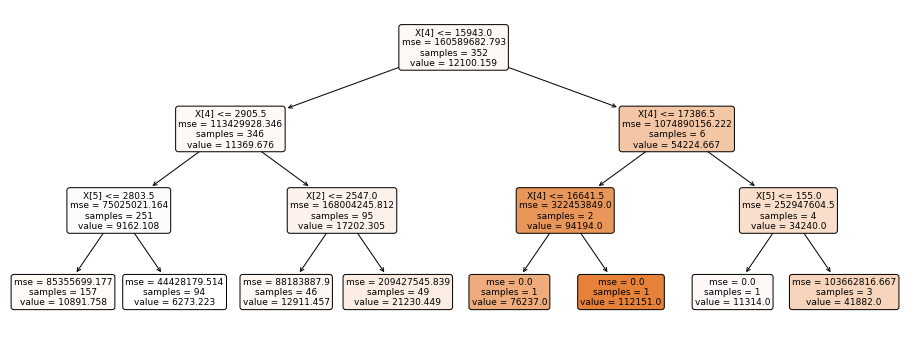

In [5]:
plt.figure(figsize=(16, 6))
expl = tree.plot_tree(regressor.fit(X.train, Y.train),
               filled=True, rounded=True, fontsize=9)

### Variables Importance

Whenever a tree is grown (fit) we can examine the results by accessing the properties of the object created. In this case, the object is what we've called `regressor`. To check variables importance, we must access the property called `feature_importances_`

    >>> my_tree.feature_importances_

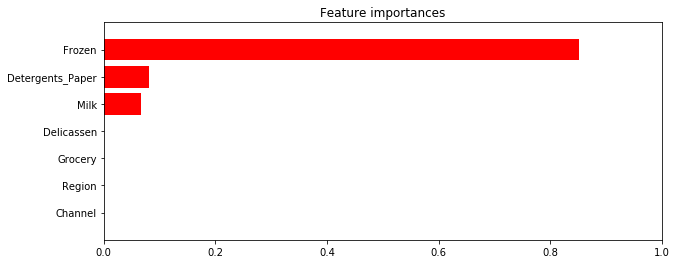

In [6]:
features_importance(regressor, X)

### Understanding the tree structure (partially from [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py))

From an example in SciKit Learn pages. Do not try this at home!

In [7]:
def explain_tree(regressor):
    n_nodes = regressor.tree_.node_count
    children_left = regressor.tree_.children_left
    children_right = regressor.tree_.children_right
    feature = regressor.tree_.feature
    threshold = regressor.tree_.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s (leaf node)" % (node_depth[i] * "  ", i))
        else:
            print("%snode=%s: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "  ",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))

In [8]:
explain_tree(regressor)

The binary tree structure has 15 nodes and has the following tree structure:
node=0: go to node 1 if X[:, 4] <= 15943.0 else to node 8.
  node=1: go to node 2 if X[:, 4] <= 2905.5 else to node 5.
    node=2: go to node 3 if X[:, 5] <= 2803.5 else to node 4.
      node=3 (leaf node)
      node=4 (leaf node)
    node=5: go to node 6 if X[:, 2] <= 2547.0 else to node 7.
      node=6 (leaf node)
      node=7 (leaf node)
  node=8: go to node 9 if X[:, 4] <= 17386.5 else to node 12.
    node=9: go to node 10 if X[:, 4] <= 16641.5 else to node 11.
      node=10 (leaf node)
      node=11 (leaf node)
    node=12: go to node 13 if X[:, 5] <= 155.0 else to node 14.
      node=13 (leaf node)
      node=14 (leaf node)


### Evaluating the tree

What's the **$\text{F1}$** of this tree when making predictions? We **never** evaluate a predictor using a single split or a single measure. Instead, we apply CV to evaluate its performance, on average, over different splits from the training set, to foresee what is its expected performance in training, no matter what portion of the data is used to train the algorithm.

To finally evaluate the tree, we must compute the same metric over the test set, without CV (no extra levels of paranoia, yet).

To be sure that our metrics are OK, we will also repeat the above process to guarantee the our initial splitting is not conditioning very much the final evaluation metric.

In [9]:
def cv_regression(my_dataset, depth=3, num_iterations=20):
    # I will store results here
    train_scores = []
    test_scores = []

    for i in range(num_iterations):
        X, y = my_dataset.split(seed=23*i ^ 2)
        estimator = DecisionTreeRegressor(random_state=0, max_depth=depth)
        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train,
                                       scoring='neg_root_mean_squared_error')
        train_scores.append(np.median(train_metric))
        test_score = mean_squared_error(y.test, estimator.predict(X.test),
                                        squared=False)
        test_scores.append(test_score)

    return train_scores, test_scores

In [10]:
cv_scores, test_scores = cv_regression(wholesale)

print('Training median RMSE: {:.4f} +/- {:.2f}%'.format(
    -np.median(cv_scores), np.std(cv_scores)*100.))
print('Test RMSE: {:.4f} +/- {:.2f}%'.format(
    np.median(test_scores), np.std(test_scores)*100.))

# This is simply to keep track of my results
regression_results.update({'regression': [-np.median(cv_scores), np.median(test_scores)]})

Training median RMSE: 12944.2812 +/- 148014.46%
Test RMSE: 12542.5902 +/- 199084.45%


We we still need to be sure that our initial split (line 7) is not biassed. 

    X, y = my_dataset.split(seed=23*i ^ 2)

To solve that, we repeat the CV process to ensure that we repeatedly evaluate (line 6) with a different split each time:

    for i in range(num_iterations):


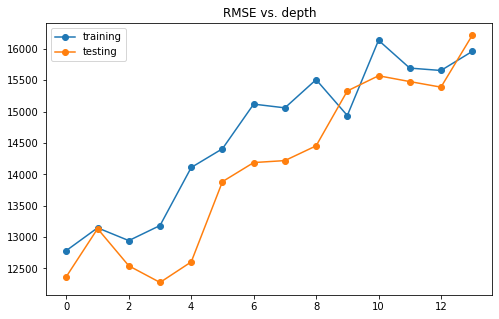

In [11]:
min_depth = 1
max_depth = 15
metric_train = []
metric_test = []
for i in range(min_depth, max_depth):
    train, test = cv_regression(wholesale, depth=i)
    metric_train.append(-np.median(train))
    metric_test.append(np.median(test))

# plot the results
pd.DataFrame(
    {'training': metric_train, 'testing': metric_test}
).plot(legend=True, style='o-', figsize=(8, 5), title="RMSE vs. depth")

What is the best depth that we can obtain? It seems that increasing the depth is nor improving performance but increasing the error. Trees are not very good regressors... unless you play a little bit with parameters.

<Figure size 648x504 with 0 Axes>

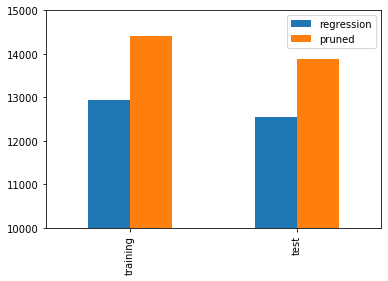

In [12]:
opt_training_scores, opt_test_scores = cv_regression(wholesale, depth=6)

plot_compare(regression_results, 'pruned', np.negative(opt_training_scores), 
             opt_test_scores, 10000, 15000)

## Classification Example

Let's build, using the same dataset a classification case. To do so the goal of this new model will be predicting the channel used by the customer (1 or 2), so we have a **binomial** classification problem.

In [13]:
wholesale = Dataset(data_url)
wholesale.set_target('Channel')

X, Y = wholesale.split()
classification_results = {}

classifier = DecisionTreeClassifier(random_state=0, max_depth=3)
classifier.fit(X.train, Y.train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### Display the tree

Colors correspond to the different classes, and color intensity corresponds to Gini index (i.e.: impurity: the purer the darker).

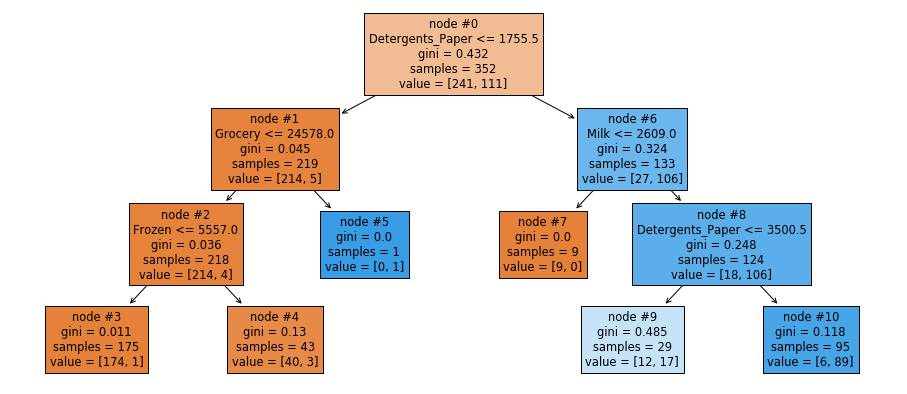

In [14]:
plt.figure(figsize=(16, 7))
tree.plot_tree(classifier, feature_names=wholesale.feature_names, 
               node_ids=True, filled=True);

### Variables importance

Feature importance is calculated as the decrease in **node impurity weighted by the probability of reaching that node**. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

Scikit learns computes the node importance using the following expression to compute the node importance:

\begin{equation}
    ni_j = w_j C_j - w_{left(j)} C_{left(j)} - w_{right(j)} C_{right(j)}
\end{equation}

where:

- $ni_j$: the importance of node $j$
- $w_j$: weighted nr. of samples reaching node $j$
- $C_j$: Impurity of node $j$
- $left(j)$ / $right(j)$: child node from left/right split on node $j$

and then, **features importance** is computed as follows:

\begin{equation}
    fi_i = \frac{ \sum_{j:node\ j\ splits\ on\ feature\ i} ni_j }{ \sum_{k\ \in \ all\ nodes} ni_k }
\end{equation}

Feature importance of a feature is a sum of importances of the nodes where that feature is used to take a split decision.

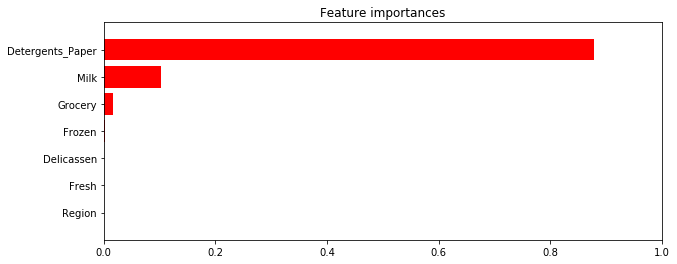

In [15]:
features_importance(classifier, X)

### Evaluating the tree

Evaluate the tree in training and test (hold out split):

1. Obtain an estimate of the training average performance metric (F1)
2. Train a model with the entire dataset
3. Validate your model against the test set, computing the validation metric against the hold-out dataset

In [16]:
def cv_classification(my_dataset, estimator, num_iterations=20):
    train_scores=[]
    test_scores=[]
    for i in range(num_iterations):
        X, y = my_dataset.split(seed=23*i ^ 2)

        # We want to call a method whose name is the argument to this func.
        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train, scoring='f1')
        train_scores.append(np.median(train_metric))

        test_score = f1_score(y.test, estimator.predict(X.test))
        test_scores.append(test_score)
    return train_scores, test_scores

In [17]:
simple_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
cv_scores, test_scores = cv_classification(wholesale, simple_tree)

print('Training median F1: {:.4f} +/- {:.2f}%'.format(
    np.median(cv_scores), np.std(cv_scores)*100.))
print('Test F1: {:.4f} +/- {:.2f}%'.format(
    np.median(test_scores), np.std(test_scores)*100.))

classification_results.update({'basic': [np.median(cv_scores), np.median(test_scores)]})

Training median F1: 0.9355 +/- 1.29%
Test F1: 0.9323 +/- 2.48%


### Manually finding the optimal tree depth

Let's try now to perform our evaluation in an scenario where we're looking for the optimum tree depth, precisely, to avoid overfittin gin our selection.

To do so, we must repeat the sequence described in the previous section with all possible __depths__ we want to try: we will try with values between 1 and 19, but you will quickly realize that trees deeper than 11 show no change in F1 metric.

In [ ]:
min_depth = 1
max_depth = 15
metric_train = []
metric_test = []
for i in range(min_depth, max_depth):
    estimator = DecisionTreeClassifier(random_state=0, max_depth=i)
    train, test = cv_classification(wholesale, estimator)
    metric_train.append(np.median(train))
    metric_test.append(np.median(test))

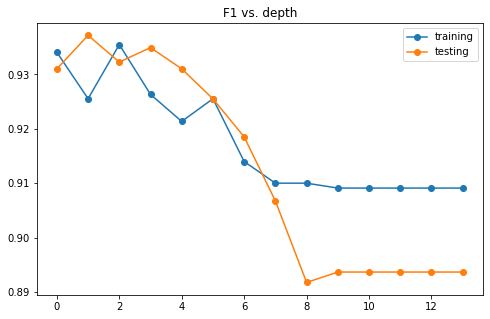

In [18]:
# plot the results
pd.DataFrame(
    {'training': metric_train, 'testing': metric_test}
).plot(legend=True, style='o-', figsize=(8, 5),  title='F1 vs. depth');

From depth=4 our test F1 starts to decrease very fast. So, my take is that depth=4 is the optimal value

In [19]:
opt_tree = DecisionTreeClassifier(
    random_state=1, max_depth=4).fit(X.train, Y.train)

f1_values = cross_val_score(opt_tree, X.train, Y.train, scoring="f1")
opt_training_score = np.median(f1_values)
print('F1 (training average): {:.4f}'.format(opt_training_score))

opt_test_score = f1_score(Y.test, opt_tree.predict(X.test))
print('F1 (test): {:.4f}'.format(opt_test_score))

F1 (training average): 0.9451
F1 (test): 0.9310


**Compare** the results with the optimal tree, against the base tree grown using suboptimal max_depth. Your test metric with optimal parameters must always be **greater or equal** than the default one.

<Figure size 648x504 with 0 Axes>

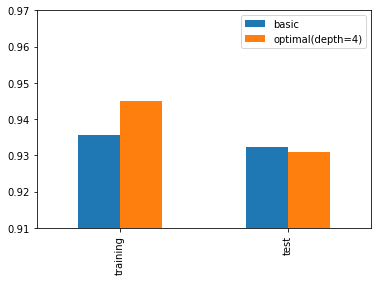

In [20]:
plot_compare(classification_results, 'optimal(depth=4)', 
             opt_training_score, opt_test_score);

### Cost Complexity Pruning

This pruning technique is parameterized by the cost complexity parameter, `ccp_alpha`. Greater values of ccp_alpha increase the number of nodes pruned. 

**Our problem is to find the optimal value for $\alpha$**.

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first.

In [21]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X.train, Y.train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [22]:
def plot_effective_alphas():
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(6)
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker='.', drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set");

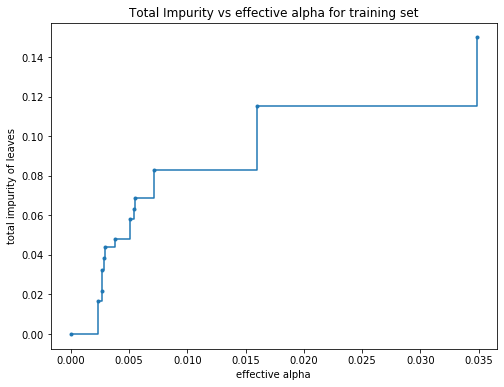

In [23]:
plot_effective_alphas()

Next, we train a collection of decision trees using different values for alphas taken from the list of effective alphas. This is just a way of avoiding to blindly search for optimal alpha values among a long list.

The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, `clfs[-1]`, with one node.

In [24]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X.train, Y.train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2817756667589173


Here we show that the number of nodes and tree depth decreases as alpha increases.

In [25]:
def plot_alphas():
    global clfs, ccp_alphas
    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    fig, ax = plt.subplots(2, 1)
    fig.set_figwidth(6)
    fig.set_figheight(8)

    ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")

    ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

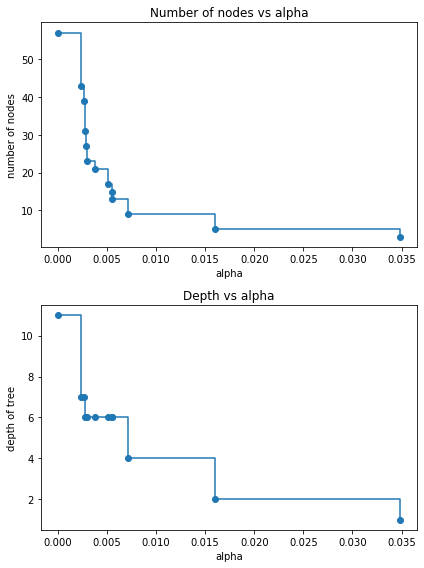

In [26]:
plot_alphas()

When `ccp_alpha` is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting ccp_alpha=0.015 maximizes the testing accuracy.

In [27]:
def plot_alpha_scores():
    global ccp_alphas, train_scores, test_scores

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(6)
    ax.set_xlabel("alpha")
    ax.set_ylabel("F1")
    ax.set_title("F1 vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    plt.show()

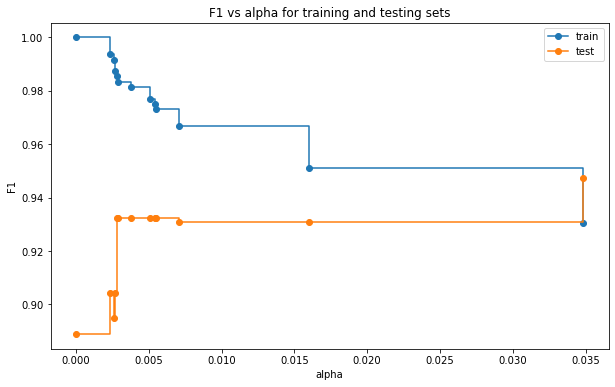

In [28]:
train_scores = [f1_score(clf.predict(X.train), Y.train) for clf in clfs]
test_scores = [f1_score(clf.predict(X.test), Y.test) for clf in clfs]

plot_alpha_scores()

In our example it seems that in order to maximize the value of F1 in testing; we should choose a value of `alpha` between 0.005 and 0.007 (if you take a look to the list of `ccp_alphas` you can check that it is: 0.00550964). That value maximizes F1 in test, while keeping a good F1 value in training.

<Figure size 648x504 with 0 Axes>

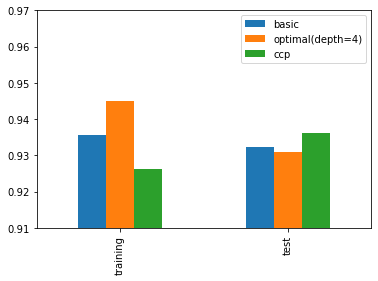

In [29]:
ccp = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0055)
ccp_train, ccp_test = cv_classification(wholesale, ccp)

plot_compare(classification_results, 'ccp', ccp_train, ccp_test);

### Grid search

What is the optimal depth for this tree given the results obtained with CV? Instead of looking at a plot, we can use the grid search over the parameters we want to try, and for the range of values we decide. The result is a much simpler approach to the problem where you don't have to write the loop, and a single call does all the job for you.

In [30]:
parameters = {'max_depth':range(min_depth, max_depth)}
grid_tree = GridSearchCV(DecisionTreeClassifier(), scoring='f1', 
                         param_grid=parameters)
grid_tree.fit(X.train, Y.train)
best_tree = grid_tree.best_estimator_

print('Optimal F1: {:.4f}, for max_depth={}'.format(
    grid_tree.best_score_, grid_tree.best_params_['max_depth']))

Optimal F1: 0.9457, for max_depth=4


### Working with the probabilities of the estimations

The predicted class probability is the fraction of samples of the same class in a leaf. We can apply __laplace smoothing__ or play with the __threshold__ to be applied to consider when to assign a leaf to each class to find better results than those obtained with the default 0.5 probability.

In the code below, we obtain the prediction probabilities for the 23rd sample in the test set.

In [31]:
sample = X.test.iloc[23, :].values.reshape(1, -1)
leaf_id = classifier.apply(sample)
raw_probs = classifier.predict_proba(sample)[0]

print('Leaf node ID................:', leaf_id[0])
print('Decision path:\n', classifier.decision_path(sample), sep='')
print('Raw Probabilities...........:', ', '.join(['{:.2f}'.format(prob) for prob in raw_probs]))
print('Nr. of samples of leaf node.:', classifier.tree_.n_node_samples[leaf_id][0])
print('Impurity (Gini) of leaf node:', classifier.tree_.impurity[leaf_id][0])
print('Samples from each class.....:', classifier.tree_.value[leaf_id].flatten())

Leaf node ID................: 9
Decision path:
  (0, 0)	1
  (0, 6)	1
  (0, 8)	1
  (0, 9)	1
Raw Probabilities...........: 0.41, 0.59
Nr. of samples of leaf node.: 29
Impurity (Gini) of leaf node: 0.4851367419738407
Samples from each class.....: [12. 17.]


### Laplacian Correction (Smoothing)

Let's implement a simple function that will compute the smoothed probabilities for a leaf node, given the proportions it presents. Remember that this method smooths probability estimates that are too extreme because of the small size of the sample that reaches leaf node.

$$ P(k) = \frac{k+1}{N+C} $$

In [32]:
def laplacian_correction(K, C=2):
    """
    K = array with the number of samples from each class
    C = numer of classes (default=2)
    """
    N = K.sum()       # total nr of samples in this node
    prob = []
    for i, k in enumerate(K):
        prob.append((k+1)/(N+C))
    return prob

# the list with the nr of elements from each class (flattened)
K = classifier.tree_.value[leaf_id].flatten()
raw_probs = classifier.predict_proba(sample)[0]
laplace_probs = laplacian_correction(K)

print('Raw Probabilities:', 
      ', '.join(['{:.2f}'.format(prob) for prob in raw_probs]))
print('Laplace Probs....:', 
      ', '.join(['{:.2f}'.format(prob) for prob in laplace_probs]))

Raw Probabilities: 0.41, 0.59
Laplace Probs....: 0.42, 0.58


## Optimization techniques

### Bagging

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

We're producing `cv` splits, and for each of them we're growing 100 trees, each with a bootstrapped sample of the training set, to produce a classification, based on voting (hard or soft).

<Figure size 648x504 with 0 Axes>

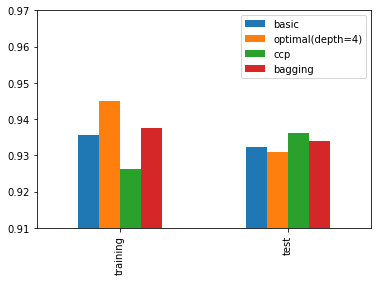

In [33]:
bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=100,
    max_features=wholesale.num_features,
    max_samples=0.5,
    oob_score=True,
    random_state=0, n_jobs=-1)
bagging_train, bagging_test = cv_classification(wholesale, bagging)

plot_compare(classification_results, 'bagging', bagging_train, bagging_test);

The result is better than the one obtained by simply growing a single tree.

### Random Forests

Now, we're not only going to pick subsets of the training set to train a number of trees, but also to select subset of features. In the end, the classification will be performed by the avearege prediction made by the grown trees.

<Figure size 648x504 with 0 Axes>

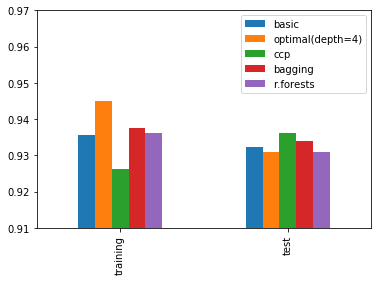

In [34]:
rf = RandomForestClassifier(n_estimators=100,
                            max_features=3,     # <---- difference w Bagging
                            max_depth=4,
                            oob_score=True,
                            random_state=0, n_jobs=-1)

rf_train, rf_test = cv_classification(wholesale, rf)

plot_compare(classification_results, 'r.forests', rf_train, rf_test)

The result is much better than the one obtained by simply applying grid search over the max_depth parameters with cross-validation, but slightly worse than in the bagging case.

### Boosting

Gradient Tree Boosting or Gradient Boosted Trees (GBT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

<Figure size 648x504 with 0 Axes>

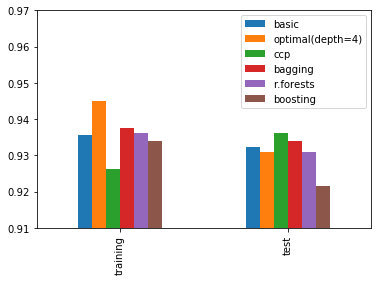

In [35]:
gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=1.0,
                                max_features=3,
                                max_depth=4, 
                                random_state=0)

gb_train, gb_test = cv_classification(wholesale, gb)

plot_compare(classification_results, 'boosting', gb_train, gb_test)

## Hyperparameter tuning

One of the most important phases in trees is deciding on what is the best combination of parameters that control the optimal values for

- depth of the tree, 
- min number of samples per leaf,
- min number of samples to perform a split,
- max number of features to consider when looking for the best split,
- ...

All these parameters control the growth of the tree, and given the lack of other pruning mechanisms, this is the best way of considering that your tree model gets "**pruned**" to avoid overfitting.

How to perform gridsearch or hyper parameter tuning over Gradient Boosting trees?


In [36]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.5, 1.0],
    "min_samples_split": [0.05, 0.1, 0.5],
    "min_samples_leaf": [0.05, 0.1, 0.5],
    "max_depth":[2, 3, 4],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.1, 0.5, 0.8, 1.0],
    "n_estimators":[10, 100, 1000]
    }

In [37]:
# Grid search takes 30 or more minutes, so I disable it.
# grid_gb = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)
# grid_gb.fit(X.train, column_or_1d(Y.train))
# score = grid_gb.score(X.train, column_or_1d(Y.train))
# best_params = grid_gb.best_params_

# I include the result here to avoid having to run this cell again
score = 0.9773
best_params = {'criterion': 'mae', 'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'log2',
               'min_samples_leaf': 0.1, 'min_samples_split': 0.05, 'n_estimators': 1000, 'subsample': 0.5}

print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

Score: 0.9773
Best Params:
{'criterion': 'mae', 'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.05, 'n_estimators': 1000, 'subsample': 0.5}


After a very long run, we find that optimal setup is:

- criterion': 'mae', 
- learning_rate': 0.1, 
- max_depth': 4, 
- max_features': 'log2', 
- min_samples_leaf': 0.1, 
- min_samples_split': 0.05, 
- n_estimators': 1000, 
- subsample': 0.5

<Figure size 648x504 with 0 Axes>

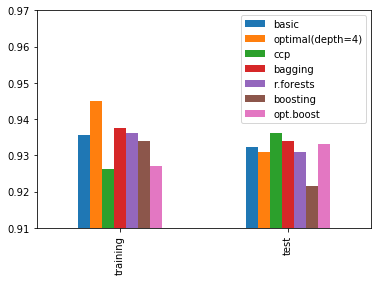

In [38]:
optimal_gb = GradientBoostingClassifier(n_estimators=1000,
                                        loss='deviance',
                                        min_samples_leaf=0.1,
                                        min_samples_split=0.05,
                                        subsample=0.5,
                                        learning_rate=0.1,
                                        max_features='log2',
                                        max_depth=4,
                                        random_state=0)

opt_gb_train, opt_gb_test = cv_classification(wholesale, optimal_gb)
plot_compare(classification_results, 'opt.boost', opt_gb_train, opt_gb_test);